In [ ]:
!pip install pmdarima
!pip install yfinance
import yfinance as yf

In [63]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from datetime import datetime
from numpy.linalg import LinAlgError

import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment
from sklearn.metrics import mean_squared_error

plt.rcParams["figure.figsize"] = (15, 7.5)

In [64]:
end = datetime.now()
start = datetime(end.year -5 , end.month, end.day)

stocks = ['AAPL','MSFT','GOOG','AMZN']

df = pd.DataFrame()
for stock in stocks:
  globals()[stock] = yf.download(stock,start,end)
  globals()[stock]['Ticker'] = stock
  df = df.append(globals()[stock])

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [65]:
df

,Open,High,Low,Close,Adj Close,Volume,Ticker
Date,,,,,,,
2018-03-20,43.810001,44.200001,43.735001,43.810001,41.764996,78597600,AAPL
2018-03-21,43.759998,43.772499,42.814999,42.817501,40.818821,148219600,AAPL
2018-03-22,42.500000,43.169998,42.150002,42.212502,40.242062,165963200,AAPL
2018-03-23,42.097500,42.480000,41.235001,41.235001,39.310192,164115200,AAPL
2018-03-26,42.017502,43.275002,41.610001,43.192501,41.176327,150164800,AAPL
...,...,...,...,...,...,...,...
2023-03-14,93.830002,95.070000,92.709999,94.879997,94.879997,60912700,AMZN
2023-03-15,93.220001,96.669998,93.070000,96.199997,96.199997,70731800,AMZN
2023-03-16,95.750000,100.989998,95.610001,100.040001,100.040001,84446900,AMZN


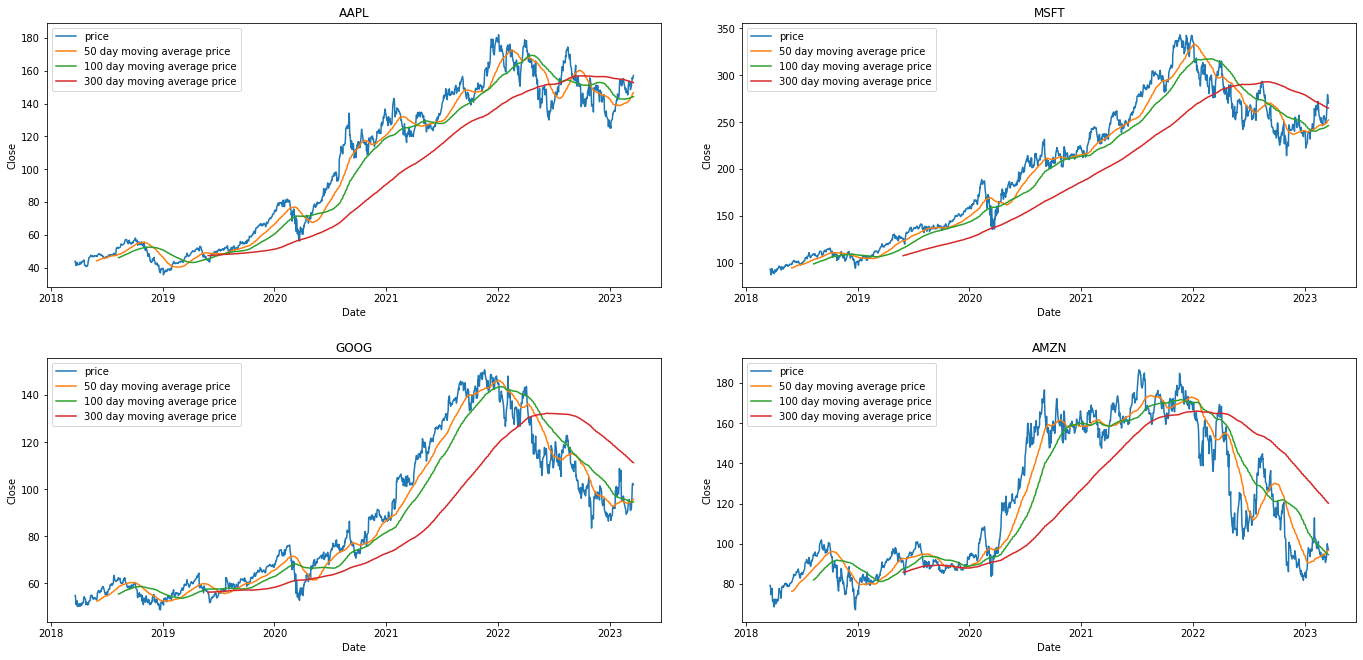

In [66]:
fig, axes = plt.subplots(2,2,figsize=(20,10))
fig.tight_layout(pad=5)

for (i, ax), stock in zip(enumerate(axes.ravel()),stocks):
  sns.lineplot(x=df.loc[df['Ticker']==stock,'Close'].index,y=df.loc[df['Ticker']==stock,'Close'],ax=ax, label='price').set(title=stock)
  sns.lineplot(x=df.loc[df['Ticker']==stock,'Close'].index,y=df.loc[df['Ticker']==stock,'Close'].rolling(50).mean(),ax=ax, label='50 day moving average price')
  sns.lineplot(x=df.loc[df['Ticker']==stock,'Close'].index,y=df.loc[df['Ticker']==stock,'Close'].rolling(100).mean(),ax=ax, label='100 day moving average price')
  sns.lineplot(x=df.loc[df['Ticker']==stock,'Close'].index,y=df.loc[df['Ticker']==stock,'Close'].rolling(300).mean(),ax=ax, label='300 day moving average price')

In [67]:
for stock in stocks:
  df.loc[df['Ticker']==stock,'Daily Return'] =  df.loc[df['Ticker']==stock,'Adj Close'].pct_change()

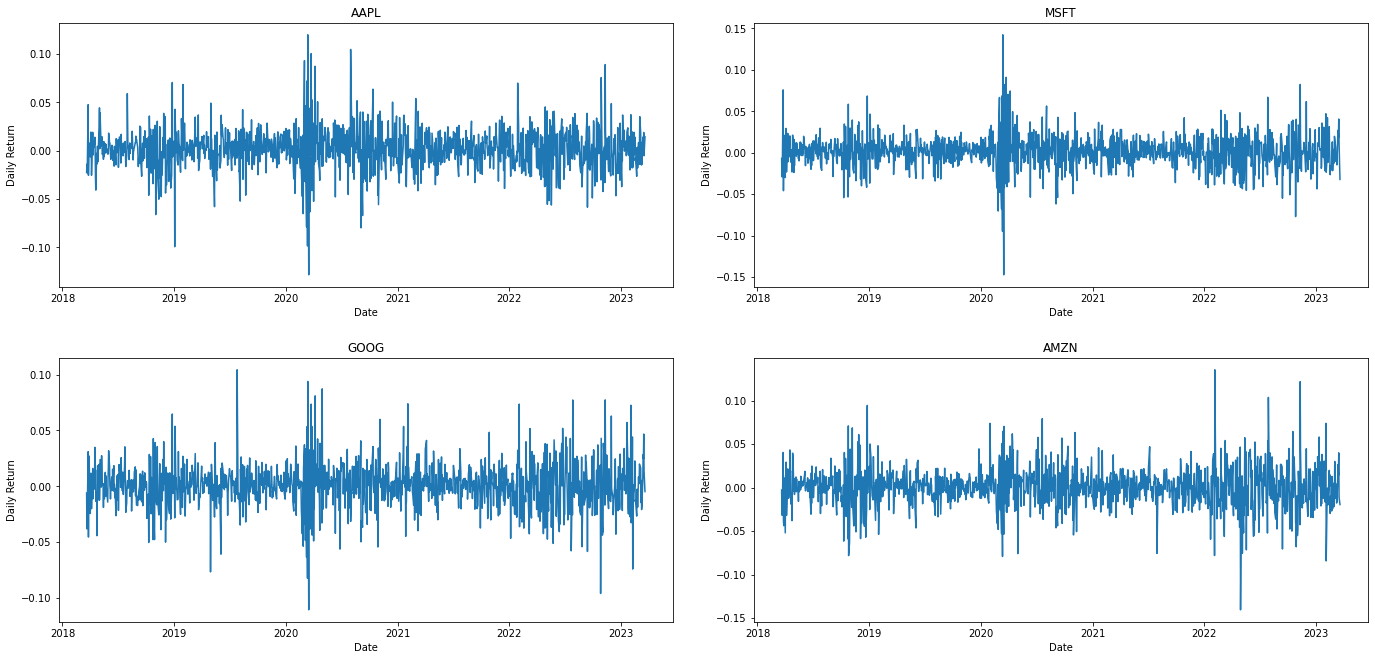

In [68]:
fig, axes = plt.subplots(2,2,figsize=(20,10))
fig.tight_layout(pad=5)

for (i, ax), stock in zip(enumerate(axes.ravel()),stocks):
  sns.lineplot(data=df[df['Ticker']==stock],x=df[df['Ticker']==stock].index,y='Daily Return',ax=ax).set(title=stock)

In [69]:
daily_return_df = df.reset_index().pivot(index='Date',columns='Ticker',values='Daily Return').dropna()
closing_price_df = df.reset_index().pivot(index='Date',columns='Ticker',values='Adj Close').dropna()
daily_return_df.head()

Ticker,AAPL,AMZN,GOOG,MSFT
Date,,,,
2018-03-21,-0.022655,-0.002931,-0.006222,-0.006979
2018-03-22,-0.014130,-0.023352,-0.038318,-0.029087
2018-03-23,-0.023157,-0.031950,-0.026223,-0.029068
2018-03-26,0.047472,0.040319,0.030972,0.075705
2018-03-27,-0.025641,-0.037799,-0.045679,-0.045959


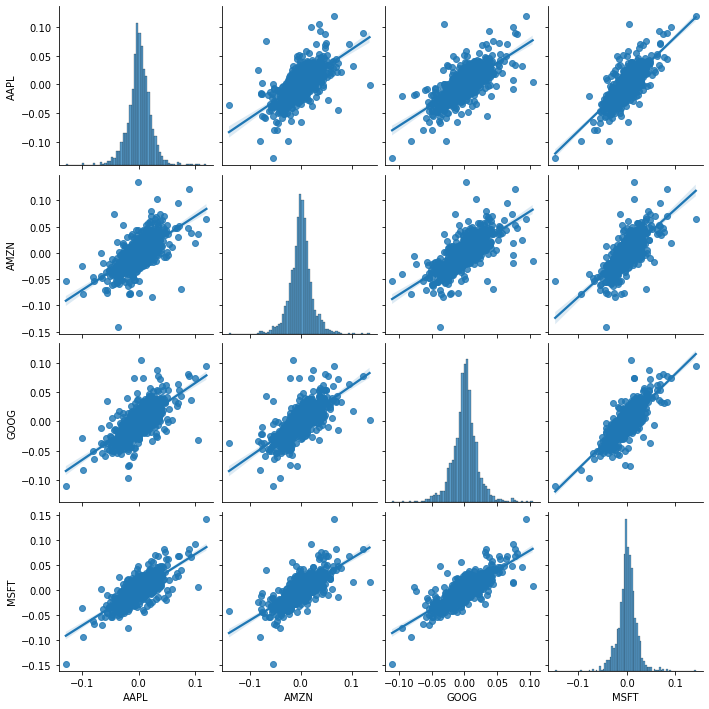

In [70]:
sns.pairplot(daily_return_df,kind='reg')

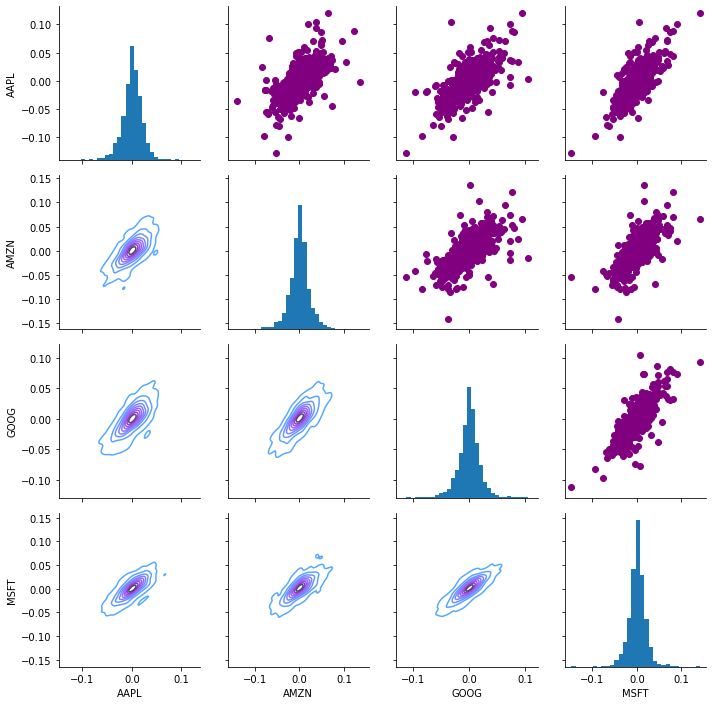

In [71]:
fig = sns.PairGrid(daily_return_df.dropna())

fig.map_upper(plt.scatter,color='purple')

fig.map_lower(sns.kdeplot, cmap='cool_d')

fig.map_diag(plt.hist, bins=30)

[Text(0.5, 1.0, 'Closing Price Correlation')]

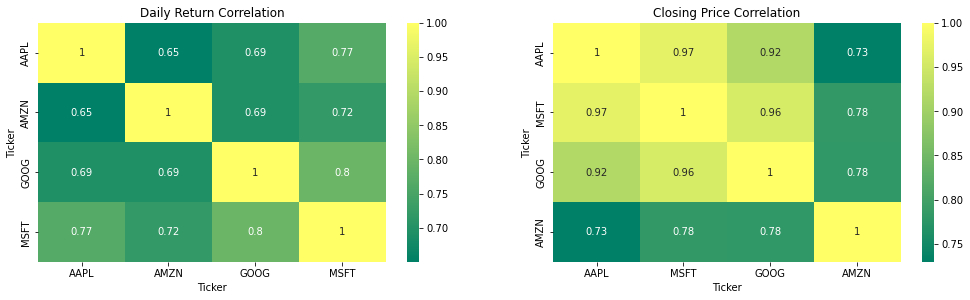

In [72]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
fig.tight_layout(pad=5)

sns.heatmap(daily_return_df.corr(),annot=True,cmap='summer',ax=axes[0]).set(title='Daily Return Correlation')
sns.heatmap(closing_price_df[stocks].corr(),annot=True,cmap='summer',ax=axes[1]).set(title='Closing Price Correlation')

In [73]:
AAPL = yf.download('AAPL','2012-01-01',datetime.now())

[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

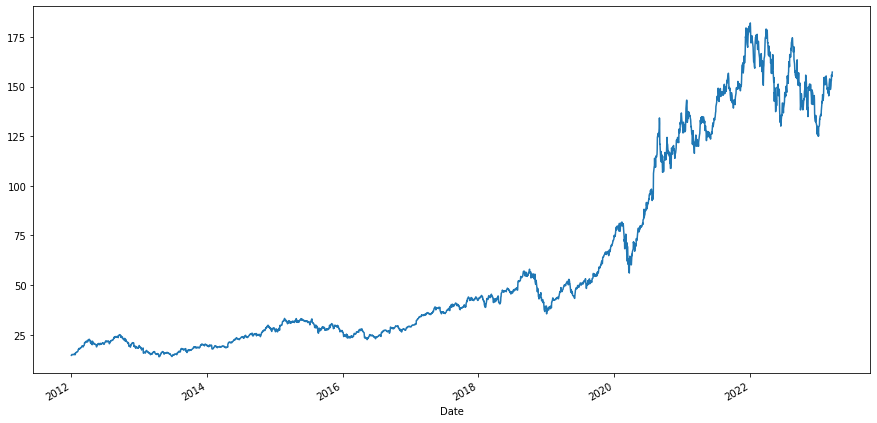

In [74]:
stock_df = AAPL.copy()
AAPL['Close'].plot()

In [75]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data  = scaler.fit_transform(stock_df[['Close']].values)

train_len = int(0.95*(len(stock_df)))
train_data = scaled_data[:train_len]

In [76]:
train_x = []
train_y = []
test_x = []
test_y = []

for i in range(60,train_len-10):
  train_x.append(train_data[i-60:i,0])
  train_y.append(train_data[i:i+10,0])

train_x, train_y = np.array(train_x), np.array(train_y)

train_x = np.reshape(train_x, (train_x.shape[0],train_x.shape[1],1))

In [77]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (train_x.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(train_x, train_y, batch_size=1, epochs=1)

2609/2609 [==============================] - 121s 45ms/step - loss: 0.0016


In [78]:
test_data = scaled_data[train_len-60:,:]

test_x = []
test_y = stock_df.loc[:,'Close'][train_len:].values

for i in range(60,len(test_data)):
  test_x.append(test_data[i-60:i,0])

test_x, test_y = np.array(test_x), np.array(test_y)

test_x = np.reshape(test_x, (test_x.shape[0],test_x.shape[1],1))

In [79]:
predictions = model.predict(test_x)
predictions = scaler.inverse_transform(predictions)
predictions_df = pd.DataFrame(predictions,index=stock_df[train_len:].index,columns=['Close'])

rmse = np.sqrt(np.mean(((predictions - test_y) ** 2)))
rmse

5/5 [==============================] - 1s 35ms/step


11.820225686484168

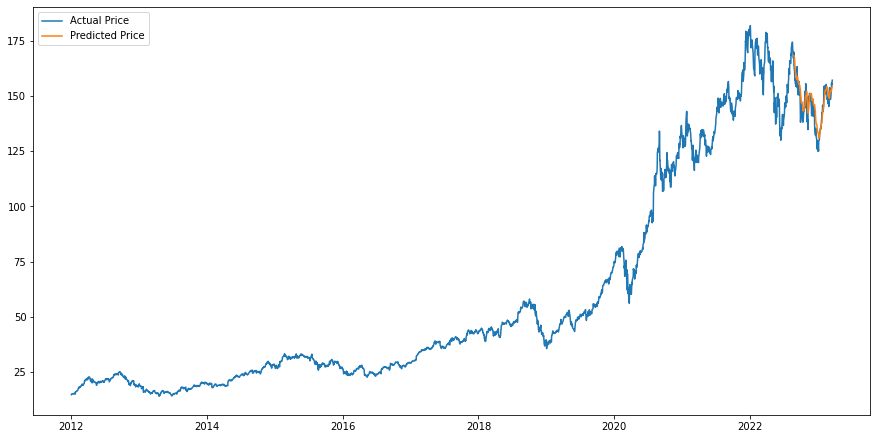

In [138]:
plt.plot(stock_df['Close'], label='Actual Price')
plt.plot(predictions_df['Close'], label='Predicted Price')
plt.legend()
plt.show()

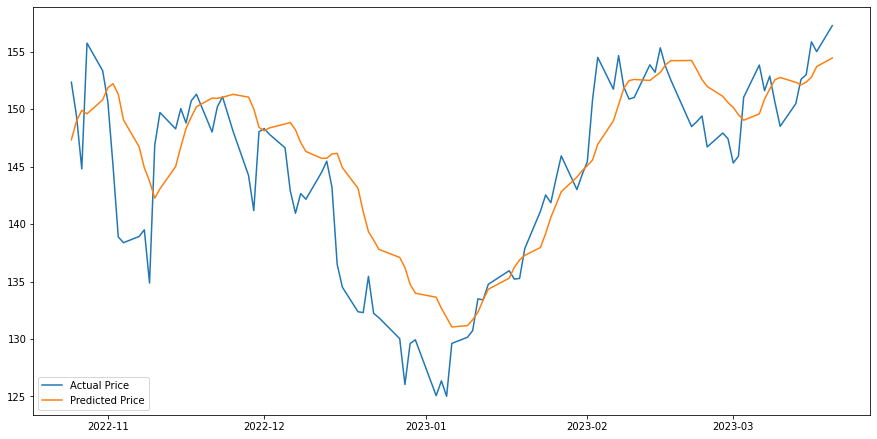

In [137]:
plt.plot(stock_df['Close'][-100:], label='Actual Price')
plt.plot(predictions_df['Close'][-100:], label='Predicted Price')
plt.legend()
plt.show()

In [141]:
import pandas_datareader.data as web
import statsmodels.tsa.api as tsa

industrial_production = web.DataReader('IPGMFN', 'fred', '1988', '2017-12').squeeze().dropna()
nasdaq = web.DataReader('NASDAQCOM', 'fred', '2009', '2017-12').squeeze().dropna()
apple = yf.download('AAPL','1975-12-01','2020-12-01')

[*********************100%***********************]  1 of 1 completed


In [142]:
apple = apple['Close']

<Axes: xlabel='Date'>

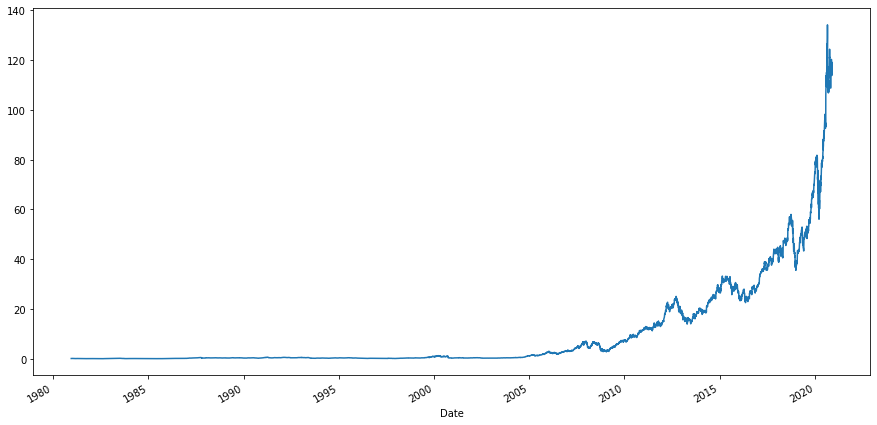

In [143]:
apple.plot()

In [144]:
train_data, test_data = apple[0:int(len(apple)*0.75)], apple[int(len(apple)*0.75):]
training_data = train_data.values

Performing stepwise search to minimize aic
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=-9445.066, Time=2.62 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=-13822.575, Time=0.51 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=inf, Time=4.24 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=-15859.574, Time=1.48 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=-17204.447, Time=3.19 sec
 ARIMA(4,3,0)(0,0,0)[0]             : AIC=-18549.746, Time=3.37 sec
 ARIMA(5,3,0)(0,0,0)[0]             : AIC=-19005.178, Time=2.19 sec
 ARIMA(6,3,0)(0,0,0)[0]             : AIC=-19503.933, Time=3.66 sec
 ARIMA(6,3,1)(0,0,0)[0]             : AIC=inf, Time=17.24 sec
 ARIMA(5,3,1)(0,0,0)[0]             : AIC=inf, Time=13.05 sec
 ARIMA(6,3,0)(0,0,0)[0] intercept   : AIC=-19501.934, Time=9.94 sec

Best model:  ARIMA(6,3,0)(0,0,0)[0]          
Total fit time: 61.499 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:               

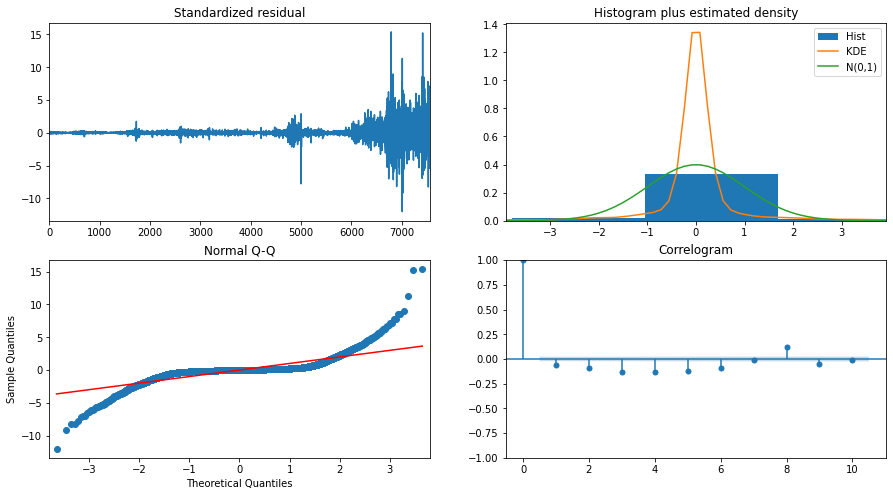

In [86]:
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       
                      max_p=6, max_q=6, 
                      m=1,              
                      d=3,          
                      seasonal=False,   
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [145]:
model = tsa.ARIMA(endog=train_data, order=(6,3,20)).fit()

In [146]:
forecast = model.forecast(steps=100)

In [147]:
forecasted_index = apple[int(len(apple)*0.75):int(len(apple)*0.75)+len(forecast)].index

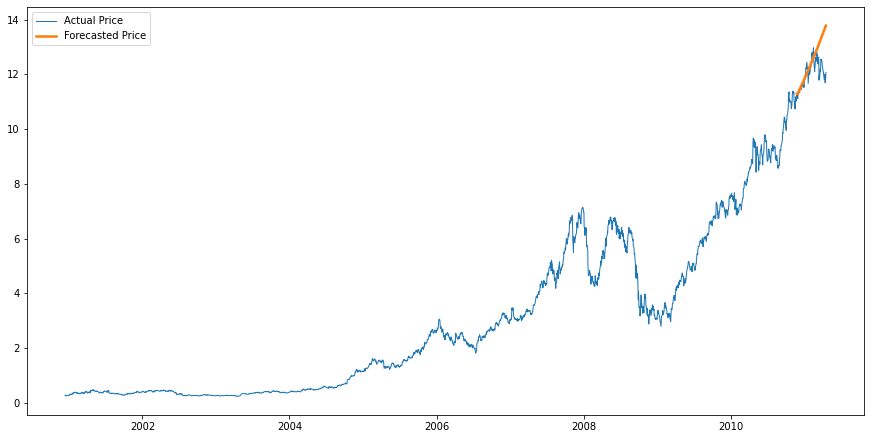

In [149]:
forecast.index = forecasted_index
plt.plot(apple['2000-12-12':forecasted_index[-1]],label='Actual Price',linewidth=1)
plt.plot(forecast,label='Forecasted Price',linewidth=2.5)
plt.legend()
plt.show()

In [98]:
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    x.plot(ax=axes[0][0], title='Residuals')
    x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=14)
    sns.despine()
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

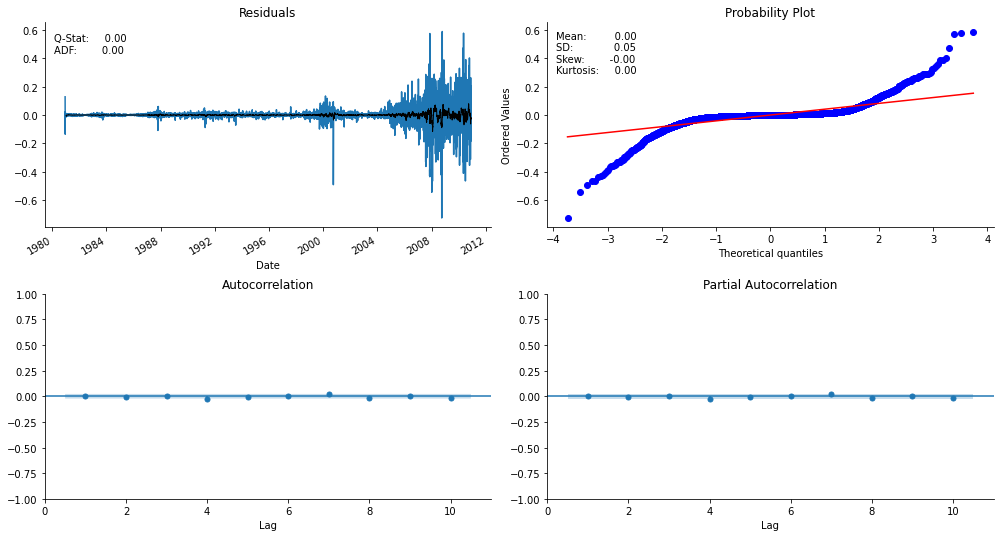

In [99]:
plot_correlogram(model.resid)

Monthly Forecasts

In [150]:
apple = apple.asfreq('M')

In [151]:
apple = apple.interpolate().dropna()

In [152]:
components = tsa.seasonal_decompose(apple, model='multiplicative')

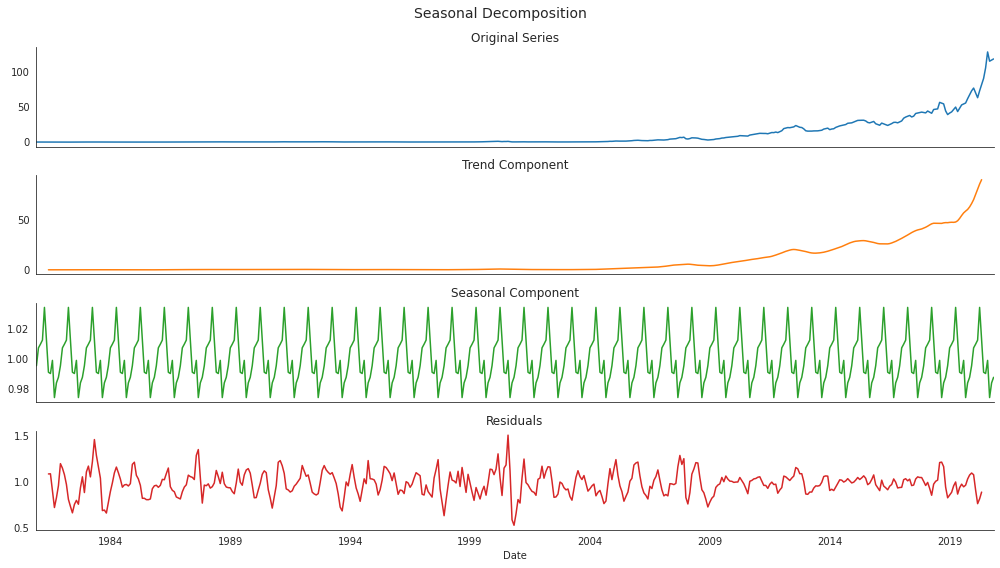

In [153]:
ts = (apple.to_frame('Original')
      .assign(Trend=components.trend)
      .assign(Seasonality=components.seasonal)
      .assign(Residual=components.resid))

with sns.axes_style('white'):
    ts.plot(subplots=True, figsize=(14, 8), title=['Original Series', 'Trend Component', 'Seasonal Component','Residuals'], legend=False)
    plt.suptitle('Seasonal Decomposition', fontsize=14)
    sns.despine()
    plt.tight_layout()
    plt.subplots_adjust(top=.91);

In [154]:
apple_log = np.log(apple)
apple_log_diff = apple_log.diff().dropna()

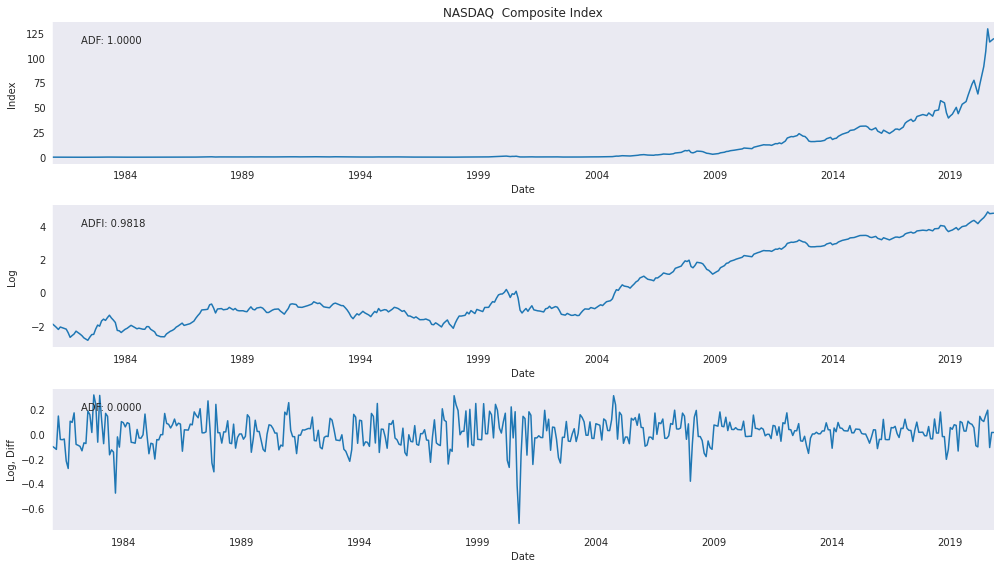

In [155]:
with sns.axes_style('dark'):
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 8))

    apple.plot(ax=axes[0],
                title='NASDAQ  Composite Index')
    axes[0].text(x=.03,
                    y=.85,
                    s=f'ADF: {tsa.adfuller(apple.dropna())[1]:.4f}',
                    transform=axes[0].transAxes)
    axes[0].set_ylabel('Index')

    apple_log.plot(ax=axes[1])
    axes[1].text(x=.03, y=.85,
                    s=f'ADFl: {tsa.adfuller(apple_log.dropna())[1]:.4f}',
                    transform=axes[1].transAxes)
    axes[1].set_ylabel('Log')

    apple_log_diff.plot(ax=axes[2])
    axes[2].text(x=.03, y=.85,
                    s=f'ADF: {tsa.adfuller(apple_log_diff.dropna())[1]:.4f}',
                    transform=axes[2].transAxes)
    axes[2].set_ylabel('Log, Diff')
    sns.despine()
    fig.tight_layout()
    fig.align_ylabels(axes)

In [156]:
train_data, test_data = apple[0:int(len(apple)*0.75)], apple[int(len(apple)*0.75):]
training_data = train_data.values

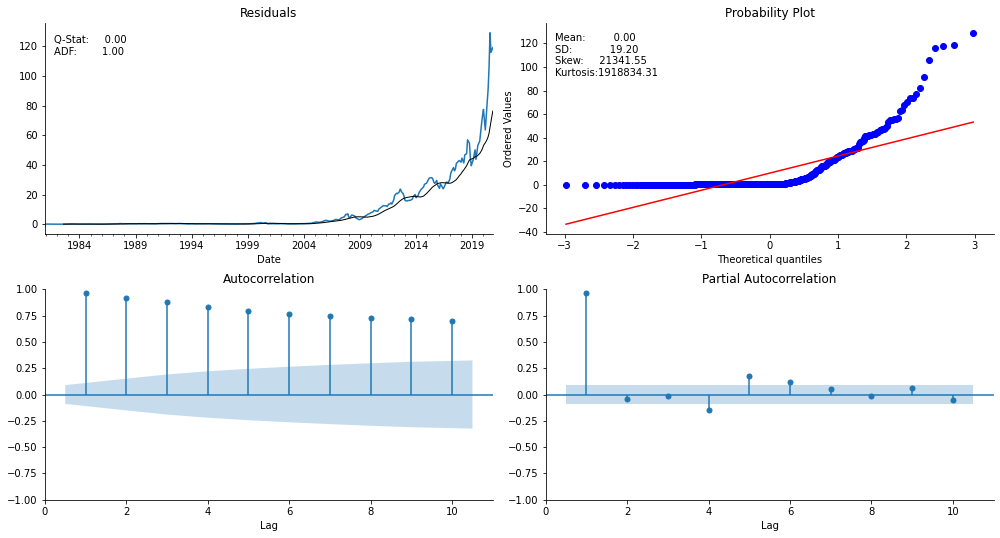

In [157]:
plot_correlogram(apple)

Performing stepwise search to minimize aic
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=470.929, Time=0.04 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=272.777, Time=0.05 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=220.561, Time=0.09 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=191.579, Time=0.11 sec
 ARIMA(4,3,0)(0,0,0)[0]             : AIC=158.771, Time=0.19 sec
 ARIMA(5,3,0)(0,0,0)[0]             : AIC=123.234, Time=0.18 sec
 ARIMA(6,3,0)(0,0,0)[0]             : AIC=63.925, Time=0.24 sec
 ARIMA(6,3,1)(0,0,0)[0]             : AIC=inf, Time=1.42 sec
 ARIMA(5,3,1)(0,0,0)[0]             : AIC=inf, Time=1.01 sec
 ARIMA(6,3,0)(0,0,0)[0] intercept   : AIC=65.921, Time=0.51 sec

Best model:  ARIMA(6,3,0)(0,0,0)[0]          
Total fit time: 4.104 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  360
Model:               

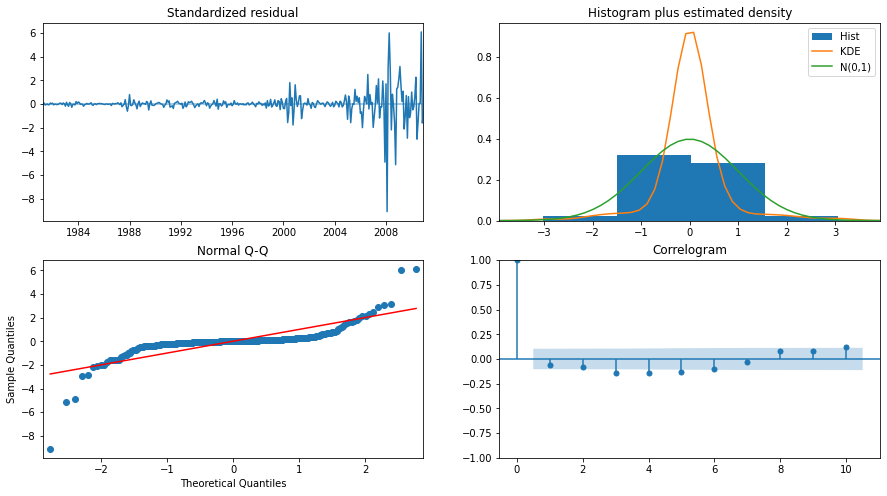

In [158]:
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       
                      max_p=6, max_q=6, 
                      m=1,              
                      d=3,          
                      seasonal=False,   
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [159]:
model = tsa.ARIMA(endog=train_data, order=(6,3,10)).fit()

In [160]:
forecast = model.forecast(steps=100)

In [161]:
forecasted_index = apple[int(len(apple)*0.75):int(len(apple)*0.75)+len(forecast)].index

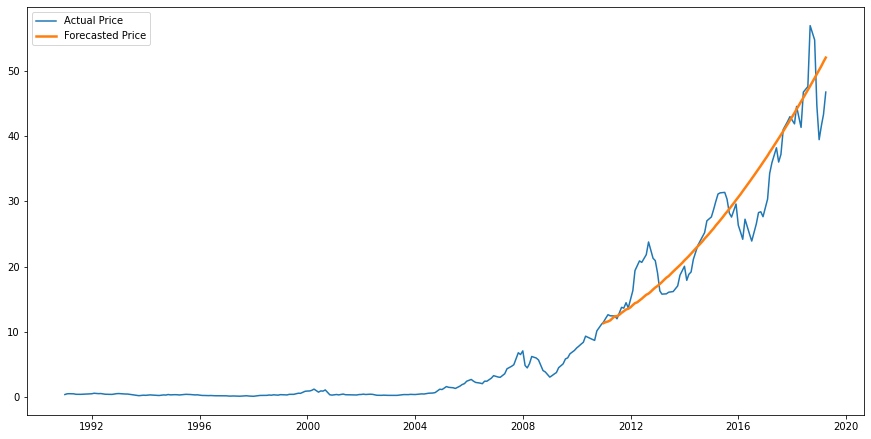

In [162]:
forecast.index = forecasted_index
plt.plot(apple['1990-12-12':forecasted_index[-1]],label='Actual Price')
plt.plot(forecast,label='Forecasted Price',linewidth=2.5)
plt.legend()
plt.show()

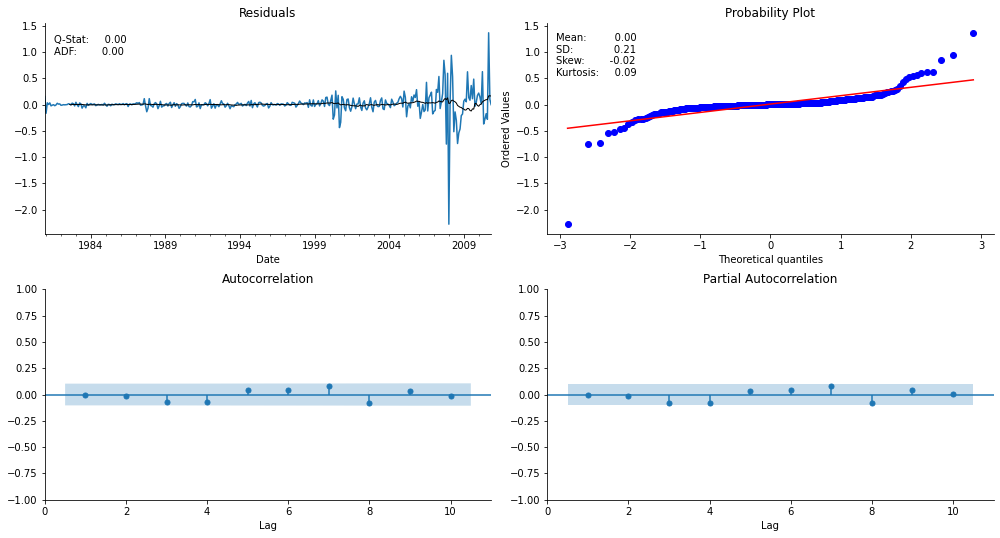

In [163]:
plot_correlogram(model.resid)